[View in Colaboratory](https://colab.research.google.com/github/sungreong/TIL/blob/master/from_decision_tree_to_Super_Learner.ipynb)

## https://www.dataquest.io/blog/introduction-to-ensembles/

## http://flennerhag.com/2017-04-18-introduction-to-ensembles/

앙상블 모델들이 머신러닝에거 핫하게 되어가고 있다.  
kaggle에서 solution을 해결 한 것들을 보면 앙상블을 이용한 것이 많다.

앙상블은 다른 모델로 부터 마지막 예측을 생성하기 위해 결합해 놓은 것이다. 그래서 더 좋은 결과가 나오는데,  
왜냐하면 앙상블은 예측을 기반한 결합이기 때문이다. 그들은 적어도 최소한의 기준선 모델을 수행합니다.

앙상블은 쉽게 성능을 높일 수 있다.

이제 앙상블이 무엇이며 왜 잘되는데 알아볼 것이다.   
* understand the fundamentals of ensembles
* know how to code them
* understand the main pitfalls and drawbacks of ensembles

## Predicting Republican and Democratic donations
 use a data set on U.S. political contributions.   
 
여기서의 주장은 과학자들이 정치인에게 기부할 때 주로 민주당에게 한다는 것이다.

그러나  말할 수 있는 것이 많다. 예를 들어 어떤 과학적 규울이 공화당 기부를 더 많이 하게 하는지 그리고 어떤 것이 민주당쪽 기부를 더 하게 되는 지와 같은 것이 있을 수 있다.  


우리는 한 걸음 더 나아가 기부금이 공화당이나 민주당에게 가장 유력한 지 여부를 예측할 것입니다.

[원본](https://github.com/fivethirtyeight/data/blob/master/science-giving/science_federal_giving.csv) 이 있지만 전처리 된  것을 사용하기 하여서 [전처리된것](https://raw.githubusercontent.com/sungreong/TIL/master/input.csv) 을 사용하겠다.

## !wget 을 이용한 http 파일  loading 하기

In [1]:
!wget https://raw.githubusercontent.com/sungreong/TIL/master/input.csv

--2018-05-31 11:57:42--  https://raw.githubusercontent.com/sungreong/TIL/master/input.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4628899 (4.4M) [text/plain]
Saving to: ‘input.csv.3’

input.csv.3         100%[===================>]   4.41M  --.-KB/s    in 0.06s   

2018-05-31 11:57:42 (68.5 MB/s) - ‘input.csv.3’ saved [4628899/4628899]



In [2]:
!ls

datalab    input.csv.1	input.csv.3
input.csv  input.csv.2	science_federal_giving.csv


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

seed =222
np.random.seed(seed)
df = pd.read_csv('input.csv.2')

In [4]:
print(df.shape)
df.columns

(100000, 11)


Index(['cand_pty_affiliation', 'cand_office_st', 'cand_office', 'cand_status',
       'rpt_tp', 'transaction_tp', 'entity_tp', 'state', 'classification',
       'cycle', 'transaction_amt'],
      dtype='object')

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [16]:
def get_train_test(test_size=0.95):
    """Split Data into train and test sets."""
    y = 1 * (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=seed)

xtrain, xtest, ytrain, ytest = get_train_test()

# A look at the data
print("\nExample data:")
df.head()


Example data:


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


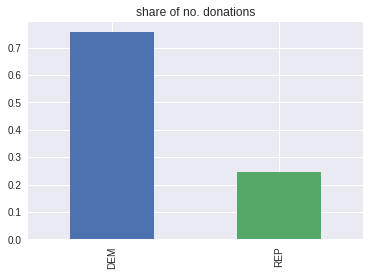

In [7]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(kind="bar", title="share of no. donations")
plt.show()

ben 의 주장에 기조한 데이터이다. 실제로  민주당과 공화당사이에서   
모든 기부금의 약 75 %가 민주당 원에게 돌아갑니다.

기부자 , 거래, 수취인에 대한 데이터는 우리가 가지고 있다.

![대체 텍스트](https://preview.ibb.co/j7Y8nd/asd.png)

얼마나 잘 예측되는지 확인하기 위해 ROC-AUC score를 사용 할 것이다. 

그래서 high precision 과 high recall 이 나오는지 볼 것이다.[참고](https://en.wikipedia.org/wiki/Precision_and_recall)


## what is an ensemble ?

만약 우리가 우리의 중요하지 않은 일에 대한 점수를 크게 하기위해서는 우리는 팀을 만들어서 모든 주제에 관해서 다뤄보면 될 것이다. 이것이 기본적인 앙상블의 아이디어이다. 몇몇 모델들 평균들로부터 예측을 결합한 특이한 에러와 전체 예측이 더 잘 된 것이 나올 것이다.  

중요한 문제는 예측들을 어떻게 결합을 할 지가 중요하다.  
팀멤버들이 과반수로 뽑은 것이 어떤것인지 상상하기는 쉽다. 이것은 머신러닝에서 분류 문제와 굉장히 유사하다.  
가장 흔히 클래스 레이블 예측을 하는 것이 과반수룰과 동등하다.  
그러나 예측들을 결합하는 방법은 다양하다 그리고 우리는 일반적으로 예측들을 모델을 사용하여 예측을 가장 잘 결합하는 방법을 배울 수 있습니다.



meta learner combine model predictions  
http://flennerhag.com/2017-04-18-introduction-to-ensembles/

![대체 텍스트](https://image.ibb.co/karB7d/asd123.png)


## Understanding ensembles by combining decision trees

앙상블 기계를 설명하기 위해 해석가능한 (if-then 구조를 사용하는 )decision tree를 이용해서 말하겠다. [참고](https://www.dataquest.io/course/decision-trees)

트리가 더 깊어 질 수록 더 복잡한 패턴을 찾을 수 있지만 과적합하는 경향이 있다.   
이것 때문에 decision tre의 복잡한 모델을 만드는 대안적인 방법이 필요하다. 




In [0]:
!pip install pydotplus
!apt-get install python-pydot

In [0]:
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [0]:
def print_graph(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=True, 
        out_file=None, 
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)  
    return Image(graph.create_png())

Decision tree ROC-AUC score: 0.672


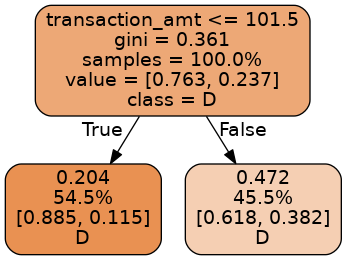

In [13]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=seed)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t1, xtrain.columns)

Decision tree ROC-AUC score: 0.751


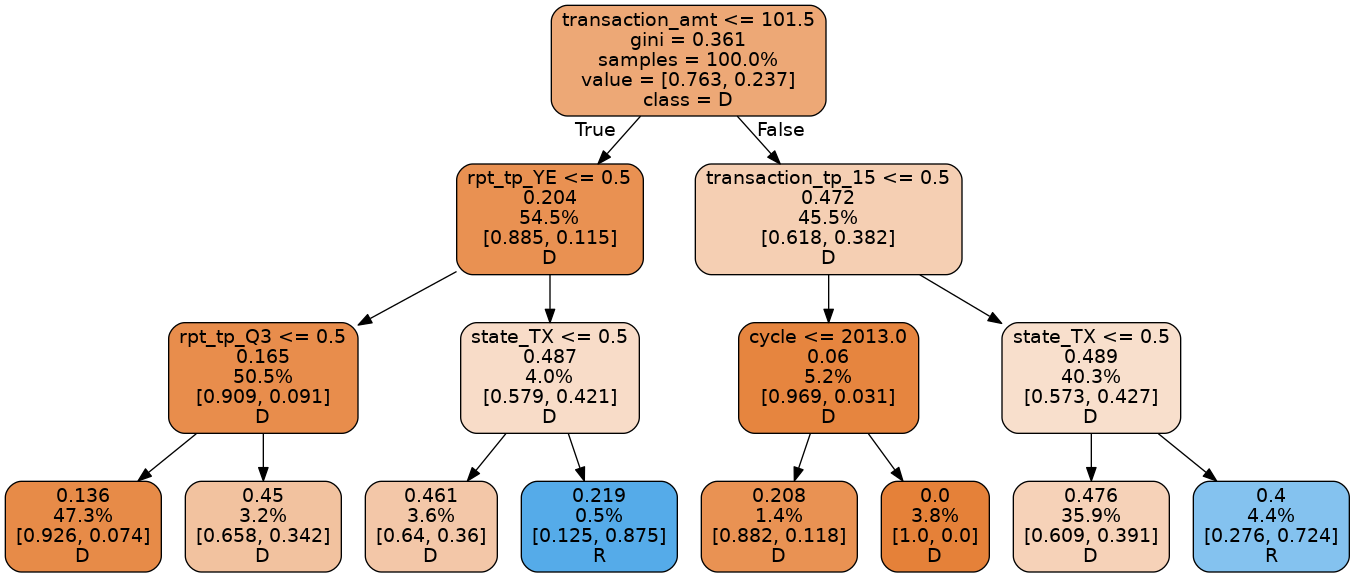

In [19]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=seed)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t2, xtrain.columns)

depth 는 고정 시키면서,  decision tree 는  width 를 증가시켜서 더 복잡하게 만들 수 있다.  
즉  몇몇 decision tree 들을 창조시켜 결합하는 것이다.  다시 말하자면 decison trees 들의 앙상블이다.

이러한 모델이 왜 도와주는지 보기 위해서 얼마나 우리가 decision tree를 위에 있는 trees 들 보다 다른 패턴을 잘 조사하게 강요할지를 고려해야 한다.

가장 간단한 해결책은 트리안에 이전에 나타났던 것을 지우면 된다.   
만약 우리가 **transaction_amt** 를 지워보자.

In [0]:
print(xtrain.columns)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Decision tree ROC-AUC score: 0.747


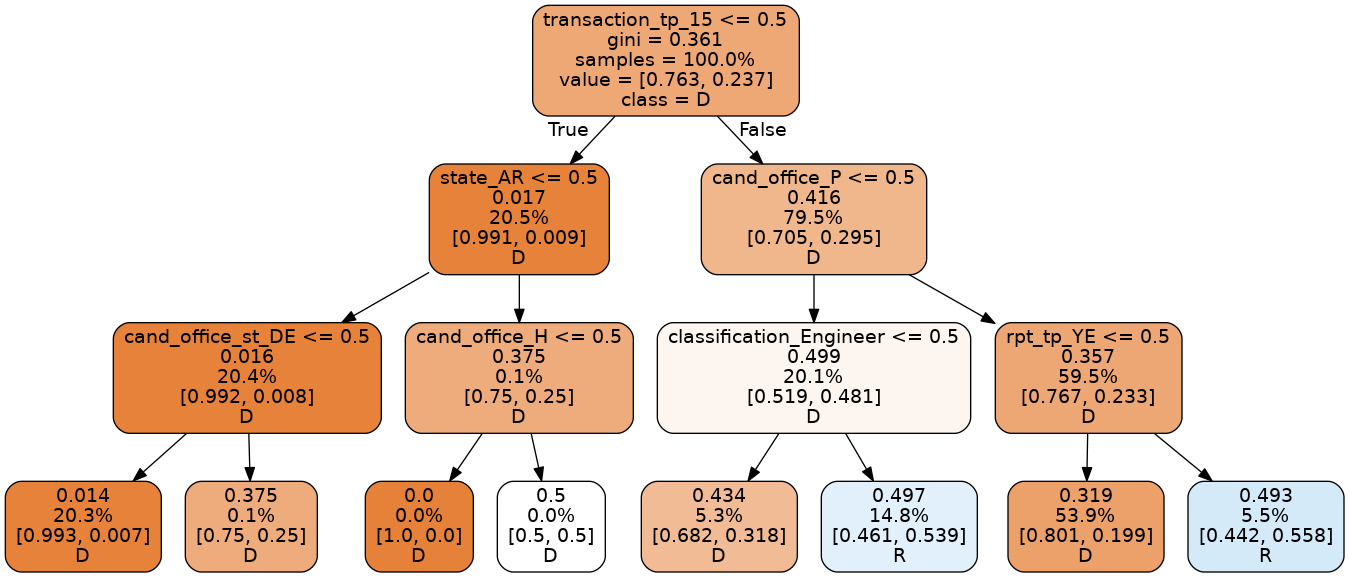

In [39]:
drop = ["transaction_amt"]

xtrain_slim = xtrain.ix[:,"cand_office_st_AK": ]
xtest_slim = xtest.ix[:,"cand_office_st_AK": ]

t3 = DecisionTreeClassifier(max_depth=3, random_state=seed)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

roc score 유사하지만,  공화당의 기부 점유율이 20.3 % 로 증가했다.   
여전히 너무 작지만 전보다는 많이 높아 졌다.  중요하게다 처음 트리와는 달리  transaction_tp_15 가 중요하게 작용한다.  
우리는 유사한 score를 얻었지만 다른 예측력있는 것을 얻게 되었다.  이것 때문에 많은 예측오차가 만들어진다.

## Interlude: why averaging predictions work
왜 우리는 예측의 평균을 기대할까? 
  
For that reason, an ensemble that averages classifier predictions is known as a **majority voting classifier.  **  
When an ensembles averages based on probabilities (as above),   
we refer to it as **soft voting**, averaging final class label predictions is known as **hard voting**

** prediction errors must be uncorrelated**

**  Generally, ensembles don't get every observation right, but in expectation it will do better than the underlying models. **

## A forest is an ensemble of trees

우리의 2개 트리들의 앙상블을 만든다면 우리는 error correlation을 확인 해야한다.  

높은 상관 에러는 나쁜 앙상블을 만들 수 있다.


In [40]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]

pd.DataFrame({"full_data": p1,
              "red_data": p2}).corr()

,full_data,red_data
full_data,1.000000,0.576278
red_data,0.576278,1.000000


In [41]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.800


위에 자료는 그렇게 높지 않은 상관성을 가지고 있어서 평균을 이용해본다.

## !!! 평균을 이용하니 SCORE가 높아진 것을 확인 할 수 있다.

실제로 앙상볼 절차는 큰 점수를 줄 수 있다.  
그러나 만약 다양한 트리들을 더 가지고 있다면 우리는 더 많은 점수를 얻을 것이다.  
어떻게 우리는 DECISION TREES 들을 설계할 때 배제하기 위해 어떤 FEATURE 를 선택해야 할까?

가장 빠른 방법으로는 실제로 randomly select a subset of feautures를 해서 fitting 시킨 다음에 각각에 대해서 예측들의 평균을 하는 것이다.  

이 과정이 ** bootstrapped averaging (often abbreviated bagging) ** 을 말하는 것이다. 
이렇게 적용한 모델이 random forest 이다. 10개의 decision tree 와 subset feature 를 3개를 이용해서 만들어 보겠다.

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=seed
)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.844


Random forest는 이전 모델에 비해서 유의미한 향상을 보여줬다.  

## Ensembles as averaged predictions

앙상블에서 두가지 중요한 관점을 보여줬다.

1. 예측 오차간의 상관성이 낮을 수록 더 좋다.
2. 더 많은 모델을 넣을 수록 더 좋다. 

지금은 단순한 simple average를 하고 있지만 우리는 가중평균을 이용한 더 복잡한 모델의 결합을 볼 수 있다.
it is helpful to formalize our ensemble as n
 models  $ f_{i} $ averaged into an ensemble  $ e $
 
$ 
e(x) = \frac{1}{n}\sum_{i=1}^n f_{i}(x).
$

여기 f는 어떠한 모델이 들어가도 된다. ex) decision tree, linear model, kernel based model , non parametric model, neural network 심지어 다른 앙상블 모델까지도!!

명심할 것은 더 많은 모델을 넣을 수록 느려지다는 거~  

다양한 모델을 넣어서 설계하기 위해서 우리는 benchmarking으로써 시작할 것이다. 

In [0]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=seed)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=seed)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=seed)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [49]:
P = np.zeros((ytest.shape[0], len([1,2,3,4,5])))
print(P)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [50]:
models = get_models()2
P = train_predict(models)
score_models(P, ytest)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done
Done.

Scoring models.
svm                       : 0.850
knn                       : 0.779
naive bayes               : 0.803
mlp-nn                    : 0.851
random forest             : 0.844
gbm                       : 0.878
logistic                  : 0.857
Done.



이 중에서 THE Gradient Boosting Machine (GBM) 이 가장 좋게 나오는 것을 알 수 있다.  
우리의 앙상블 전략에서 예측오차가 상관성이 없을 때 더 잘 나온다 했으므로 오차를 확인해 보겠다.

In [0]:
!pip install mlens

[MLENS] backend: threading


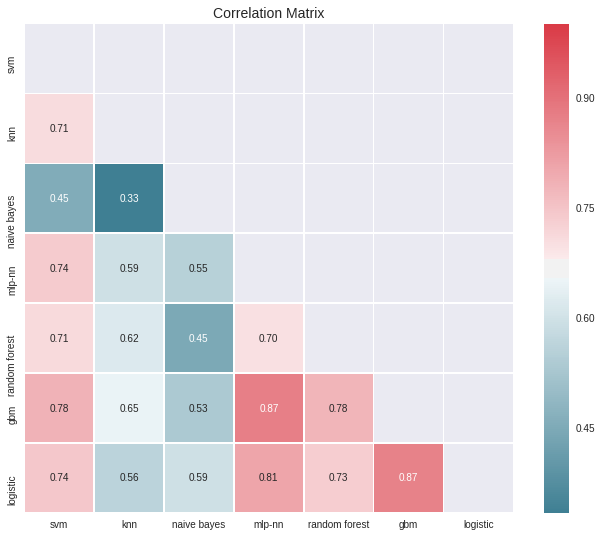

In [52]:
from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)
plt.show()

그림을 보면 에러들이 유의미하게 연관되어져 있다.  예측이 잘 된 것끼리는 상관성이 높게 나오는 것을 불 수 있다.  
아직 대부분의 correlation은 50-80 퍼져있다.  향상시키기에 아직 괜찮은 여지가 있다.   
사실 만약 분류 예측 기반한 에러 상관성을 본다면,  좀 더 나을 것이다.

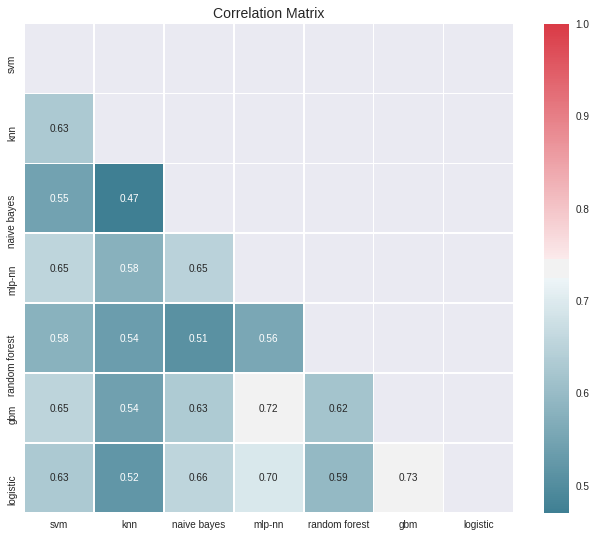

In [53]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - ytest.values).corr(), inflate=False)
plt.show()

앙상블을 만들기 위해  우리는 이전과 마찬가지로 평균 예측을 진행합니다.  
그리고 더 성능이 넘는 것을 찾아본다. 평균은 간단한 절차이다  
만약 우리가 모델 예측을 저장했다면 우리는 간단한 앙상블을 할수 있다.


In [54]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.884


In [56]:
P.head()

,svm,knn,naive bayes,mlp-nn,random forest,gbm,logistic
0,0.351309,0.333333,5.020798e-10,0.156115,0.3,0.265998,0.149805
1,0.007118,0.000000,1.085367e-68,0.010601,0.0,0.017165,0.002534
2,0.565495,0.333333,6.701134e-14,0.226278,0.2,0.328002,0.284237
3,0.044327,0.000000,2.862588e-62,0.049854,0.0,0.024914,0.024564
4,0.004237,0.000000,1.020511e-61,0.027849,0.0,0.017396,0.004619


## Visualizing how ensembles work

We've understood the power of ensembles as an error correction mechanism.   
This means that ensembles smooth out decision boundaries by averaging out irregularities. 

A decision boundary shows us how an estimator carves up feature space into neighborhood within which all observations are predicted to have the same class label. 

By averaging out base learner decision boundaries, the ensemble is endowed with a smoother boundary that generalize more naturally.

The figure below shows this in action. Here, the example is the iris data set, where the estimators try to classify three types of flowers.   
The base learners all have some undesirable properties in their boundaries, but the ensemble has a relatively smooth decision boundary that aligns with observations.   
Amazingly, ensembles both increase model complexity and acts as a regularizer!

![대체 텍스트](https://preview.ibb.co/htWsxd/ensemble.png)


해야 할 항목이 분류일 때,  앙상블을 이해하는 또다른 방법은 ROC(Receiver Operator Curve) 를 보는 것이다.  
이 커브는 우리가 trades off 를 얼마나 잘 추정하는지 볼 수 있다.(precision and recall)  
전형적으로 다른 기초 러너들은 다른 trade off 들을 가진다. 어떤 것은 recall 은 희생하면서 higher precision 을 가지거나 반대의 경우도 있다. 

하지만 비선형 meta learner 은 각각의 training point 에서 모델에 의존하게 조정할 수 있다.  
이것은 recall를 상승시키면서 precision도 상승시킬 수 있는 방법이다.


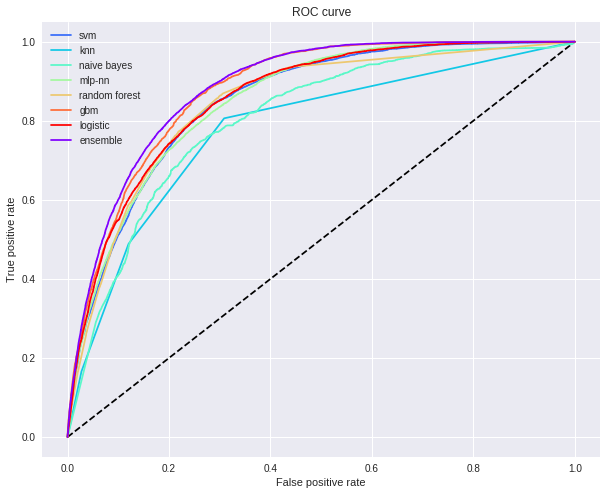

In [57]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

## Beyond ensembles as a simple average 
그러나 예측 오차의 변화를 고려할 때 더 많은 기대감을 기대하지 않겠습니까?

Some of the models perform considerably worse than others, yet their influence is just large as better performing models  
This can be quite devastating with unbalanced data sets  


An important factor for us is whether models are able to capture the full share of Republican denotations

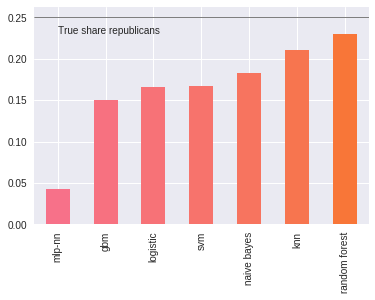

In [58]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["DEM", "REP"]
p.loc["REP", :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republicans")
plt.show()

MLP-NN 이 나쁜 영향을 주기 때문에 제거해서 해본다.

In [59]:
include = [c for c in P.columns if c not in ["mlp-nn"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.883


실제로 큰 영향을 주지는 않았다. 그래서 우리는 모델들 사이에서 우선화 즉 가중치를 주능 똑똑한 방법이 필요하다.  
앙상블에서 모델을 제거하는 것은 어쩌면 중요한 정보를 제거하는 일을 하는 것일지도 모른다.  
실제로 우리가 원하는 것은 **배우는 것 **  평균을 예측할 때 사용하는 가중치를 민감하게 하는 것이다.   
This turns the ensemble into a parametric model that needs to be trained.

** Learning to combine predictions

각각의 모델 $f_{i} $ 에서 $ \omega_{i} \in (0,1 ) $ 모델 예측에 가중치를 줘야 한다. weight 합은 1이 되게 해야한다.

$
e(x) = \sum_{i=1}^n \omega_{i}f_{i}(x)
$

이것은 이전 정의에서 사소한 변화이지만, 이것은 흥미롭다. 왜냐하면 모델들이 $ p_{i} = f_{i}(x) $ 예측들을 생선할 때, 
가중치를 학습하는 것은 이러한 예측들에서 선형 회귀를 적합시키는 것과 같기 때문이다!!

$
e(p_{1},...,p_{n}) = \omega_{1}p_{1}+ ... + \omega_{n}p_{n}
$

이러한 weight의  몇몇의 제한과 함께 선형모델에 단지 피팅하는 것을 제한 할 이유가 없다.

우리가 가장 가까운 이웃 모델에 적합하다고 가정하자.  
주어진 관측치와  인풋이 변할 때 모델 성능 변화를  적응하는 앙상블을 부여하는 가까운 이웃에 기반한 지역적인 평균을 만들어보자  


## Implementing an ensemble
we need three things:  

1. a library of **base learners** that generate predictions
2. a **meta learner** that learns how to best combine these predictions
3. a method for splitting the training data between the base learners and the meta learner.

**base learner** 들은 실제 인풋과 예측을 생성하고 있는 진행중인 모델이다.  
만약 우리가 행렬(n_samples, n_features) 로 정렬된 데이터가 있다면,  the library of base learners output a new prediction matrix  P base of size  (n_samples, n_base_learners) 각각의 컬럼들은 base learner들중의 하나로 만든 예측을 나타낸다 .

the meta learner 는 $ P_{base} $ 로 훈련되어진다   
적정한 방법안에서 데이터셋을 조정하는 결정적인 것을 의미한다.  
만약 우리가 x 에서 base learner와 x 를 예측한다면, meta learner 는 base learner training error 에 기반한 훈련을 할 것이다. 그러나 test time 때는 또 다른 $ test errors$ 에 직면하게 된다.  

그래서 test errors를 반약하는 예측  matrix $ P $ 생성하는 전략이 필요하다.  
가장 간단한 방법은 full data set을 2개르 쪼개는 것이다. 그래서 하나는 base learner 를 훈련 하고 다른 하나는 그 스스로 예측을 해보는 것이다. 이런식으로 하면 상대적으로 간단하고 빠르지만 데이터의 양이 줄어들게 된다. 그래서 작은 데이터를 하게 되다 보니 정보의 손실이 심각하고 base learner 와 meta learner 의 성능을 떨어트리게 한다.  

그래서 전체 데이터를 확보하기 우리는 ** cross-validation** 이라는 기법을 사용하게 된다.  


## Step 1: define a library of base learners

적은 인풋 데이터를 받고 만든 모델과 예측을 생성한다. 그리고 선형 회귀부터 뉴럴렛 또는 다른 앙상블까지 있다.

다양하다는 장점이 있다!!  
한가지 고려해야 할 점은 우리가 모델을 넣을 수록 점점 느려진다는 거~~ 

In [0]:
base_learners = get_models()

## Step 2: define a meta learner

어떤 meta learner 를 사용하는지는 명확하지 않지만 보통 linear model , kernel-based models(svm , knn) 혹은 tree based models를 사용한다.   
그러나 우리는 또한 meta learner 같은 다른 앙상블을 사용할 것이다. 특별한 경우에, feed-forward neural network 를 사용할 것이다.  

여기에 우리는 Gradient Boosting Machine 을 사용 할 것이다.   
우리는 GBM 의 지역적 패턴을 확인하기 위해  각각의 1000개의 트리로 제한할 것이고 또한 SUBSET은 4개의 RANDOM BASE LEARNER 를 사용할 것이다 50 % 인풋만 사용 할 것이다.  

GBM은 각각의 다른 근처의 input space 에서 base learner 의 강점에 노출되어질 것이다.  


In [0]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=seed
)

## Step 3: define a procedure for generating train and test sets

이것들을 간단하게 유지하기 위해 우리는 전체 train 데이터 셋을  training 과 base learner 의 예측 set 으로 나눌 것이다.
그리고 이러한 방법은 ** Blending ** 이라고 한다. 


In [0]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=seed)

We now have one training set of the base learners 
(
X
train_base
,
y
train_base
)  
 and one prediction set 
(
X
pred_base
,
y
pred_base
)  
 and are ready to generate the prediction matrix for the meta learner.

## Step 4: train the base learners on a training set

base-learner training data 에 base -learners libraray를 훈련하기 위해 우리는 평소와 같이 진행한다.


In [0]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [66]:
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


## Step 5: generate base learner predictions
base learner 피팅과 함께 우리는 meta learner를 예측하는 셋을 생성 할 수 있다.  
기본 학습자를 훈련시키는 데 사용되지 않은 관측치에 대한 예측을 생성합니다.  
 For each observation  $  x_{pred}^{i} \in X_{predbase} $
 in the base learner prediction set, we generate a set of base learner predictions:
 
 $
 P_{base}^{i} = (f_1(x_{pred}^{i}),...,f_n(x_{pred}^{i}))
 $
 
 When we split the data in two, this is not so hard, but with cross-validation things are more challenging.
 

In [0]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P

In [68]:
P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


## 6. Train the meta learner

The prediction matrix  $P_{base} $
 reflects test-time performance and can be used to train the meta learner:

In [69]:
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='exponential', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=222, subsample=0.5, verbose=0,
              warm_start=False)

new data 를 예측하기 위해 사용된 훈련된 앙상불을 가지게 되었다.

To generate a prediction for some observation $ x^{(j)} $
, we first feed it to the base learners. These output a set of predictions

$
p_{base}^{(j)} = (f_1(x^{(j)}),...,f_n(x^{(j)}))
$

드디어 meta learner 를 feed 했다. meta learner 를 우리에게 완성된 예측을 주었다.

$
p^{(j)} = m (p_{base}^{(j)})
$



In [0]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

In [71]:
P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done

Ensemble ROC-AUC score: 0.881


예상했던 것과 같이, 앙상블은 우리가 이전에 benchmark 했던 것을 이겼다.   
그러나 이것은 간단한 단순 평균 앙상블을 이긴것은 아니다.  
왜냐하면 우리는 절반의 데이터로 base learner 와 meta learner를 훈련되어져 있다.  
그래서 많은 정보를 잃었다. 이것을 예방하기 위해 cross-validation을 사용 할 것이다.  


## Training with cross-validation
During cross-validated training of the base learners, a copy of each base learner is fitted on $ K-1 $
 folds, and predict the left-out fold.  
 This process is iterated until every fold has been predicted.     
 The more folds we specify, the less data is being left out in each training pass.   
 This makes cross-validated predictions less noisy and a better reflection of performance during test time.  
 
 The cost is significantly increased training time.   
 Fitting an ensemble with cross-validation is often referred to as **stacking**    
 
 while the ensemble itself is known as 
 ###  the Super Learner. 
 
 To understand how cross-validation works, we can think of it as an outer loop over our previous ensemble.   
 The** outer loop** iterates over $K$
 distinct test folds, with the remaining data used for training.   
  The **inner loop** trains **the base learners** and generate predictions for the held-out data. 

In [0]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")
    
    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

 **First,** we fit our final base learners on all data:   
 in contrast with our previous blend ensemble, base learners used at test time are trained on all available data.  
 We then loop over all folds, then loop over all base learners to generate cross-validated predictions.  
 These predictions are stacked to build the training set for the meta learner, which too sees all data.
 
 The basic difference between blending and stacking is therefore that stacking allows both base learners and the meta learner to train on the full data set.  
 Using 2-fold cross-validation, we can measure the difference this makes in our case:

In [74]:
%timeit
from sklearn.model_selection import KFold

# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(10))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Fitting final base learners...done
Generating cross-validated predictions...
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done
CV-predictions done
Fitting meta learner...done

Ensemble ROC-AUC score: 0.890


stacking 은 상당한 실적향상을 출력한다.  
이 결과는 전형적인 작거나 중간 사이즈 데이터 셋의 결과이다.   
blending 을 사용하면 더 별로다.  
데이터 셋이 더 커질수록 blending 과 stacking 의 성능은 거의 비슷해진다.  

stacking 은 특히 스피드와 결점을 제시한다.   
일반적으로 우리는 cross-validation을 할때 중요한 이슈에 대해 알고 있어야 한다.

1. Computational complexity
2. Structural complexity (정보 누수의 위험)
3. Memory comsumption

앙상블을 효율적으로 작업하기 위해서는 꼭 알아야한다.  

# 1. Computational complexity

10 fold 로 stacking 했다고 가정해보자.  모든데이터에서  데이터의 90 %가 10번 모든 base learner를 훈련할 필요가 있다.  
4 base learners 에서 앙상블은 실제 최고의 base learner 보다느 40 배 느리다!!

그러나 각각의 cv-fit 은 독립적이다 그래서 우리는 순차적으로 모델을 적합시킬 필요가 없다.  
만약 우리가 모든 것을 병렬적으로 적합시킨 다면 앙상블은 기존의 것보다 4배 느려질 것이다.!!
엄청난 향상이다.  앙상발은 병렬화가 필수이다**parallelization** 그리고 가능한 가장 큰 범위의 수용서이 있어야 한다.  
모든 모델에 대해 모든 폴드를 병렬로 적용하면 앙상블에 대한 시간 패널티는 무시할 수 있습니다.  

![](https://preview.ibb.co/c1YY3J/fitting.png)

But parallelization is associated with a whole host of potentially thorny issues such as race conditions, deadlocks and memory explosion.

# 2. Structural complexity

we decide to use the entire training set to meta learner, we must worry about **information leakage**

This phenomena arises when we mistakenly predict samples that were used during training, for instance by mixing up our folds or using a model trained on the wrong subset.   

When there's information leakage in the training set of the meta learner, it will not learn to properly correct for base learner predictions errors: garbage in, garbage out. Spotting such bugs though is extremely difficult.  

# 3. Memory consumption

The final issue arises with parallelization, especially by multi-processing as is often the case in Python  
 In this case, each sub-process has its own memory and therefore needs to copy all data from the parent process.
 A naive implementation will therefore copy all data to all processes, eating up memory and wasting time on data serialization(직렬화)
 
 Preventing this requires sharing data memory, which in turns easily cause data corruption.
 
 ## Upshot: use packages
 
 The upshot is that you should use a unit-tested package and focus on building your machine learning pipeline.   
 in fact, once you've settled on a ensemble package, building ensembles becomes really easy:   
 ** all you need to do is specify the base learners, the meta learner, and a method for training the ensemble**
 
 we use [ML-Ensemble](http://ml-ensemble.com/) and build our previous generalized ensemble, but now using 10-fold cross-validation:
 
 

In [76]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=seed,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
p_sl = sl.predict_proba(xtest)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(ytest, p_sl[:, 1]))


Fitting 2 layers
Processing layer-1             done | 00:02:20
Processing layer-2             done | 00:00:03
Fit complete                        | 00:02:23

Predicting 2 layers
Processing layer-1             done | 00:00:58
Processing layer-2             done | 00:00:02
Predict complete                    | 00:01:00

Super Learner ROC-AUC score: 0.890


Inspecting the ROC-curve of the super learner against the simple average ensemble reveals how leveraging the full data enables the super learner to sacrifice less recall for a given level of precision.



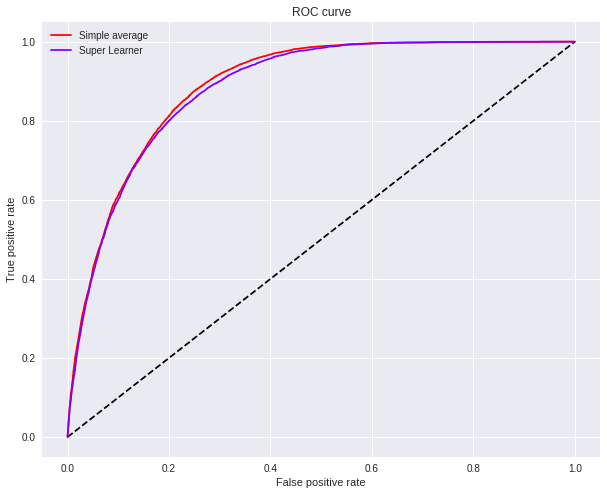

In [77]:
plot_roc_curve(ytest, p.reshape(-1, 1), P.mean(axis=1), ["Simple average"], "Super Learner")

다양한 앙상블이 있지만, 기본 재료는 똑같다.

1. a library of base learners
2.  a meta learner
3.  a training procedure

이 구성요서에서 다양하게 가지고 놀면서 다양한 앙상블을 만들 수 있다.  
https://mlwave.com/kaggle-ensembling-guide/